In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import ast
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Input


**1.Carga csv**

Se sacan las coordenadas de las regiones de interés


In [2]:
file_path = 'C:/Users/andre/Downloads/csv_final_video7.csv'
df = pd.read_csv(file_path)

df.head()

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
0,surco-rouviere-244.jpg,102026,{},3,0,"{""name"":""rect"",""x"":298,""y"":192,""width"":336,""he...","{""Region"":""vesicula""}"
1,surco-rouviere-244.jpg,102026,{},3,1,"{""name"":""rect"",""x"":259,""y"":367,""width"":135,""he...","{""Region"":""surco""}"
2,surco-rouviere-244.jpg,102026,{},3,2,"{""name"":""rect"",""x"":519,""y"":55,""width"":179,""hei...","{""Region"":""segmento4""}"
3,surco-rouviere-326.jpg,108379,{},3,0,"{""name"":""rect"",""x"":298,""y"":64,""width"":233,""hei...","{""Region"":""vesicula""}"
4,surco-rouviere-326.jpg,108379,{},3,1,"{""name"":""rect"",""x"":142,""y"":250,""width"":170,""he...","{""Region"":""surco""}"


In [3]:
# Asegurarnos de que la columna 'label' exista
df['label'] = df['region_attributes'].apply(lambda x: ast.literal_eval(x).get('Region', ''))

df[['filename', 'label']].head()

,filename,label
0,surco-rouviere-244.jpg,vesicula
1,surco-rouviere-244.jpg,surco
2,surco-rouviere-244.jpg,segmento4
3,surco-rouviere-326.jpg,vesicula
4,surco-rouviere-326.jpg,surco


In [4]:
# Función para convertir las coordenadas del formato JSON a (x_min, y_min, x_max, y_max)
def convert_to_bounding_box(region_shape_attributes):
    shape_dict = ast.literal_eval(region_shape_attributes)
    x_min = shape_dict['x']
    y_min = shape_dict['y']
    x_max = x_min + shape_dict['width']
    y_max = y_min + shape_dict['height']
    return x_min, y_min, x_max, y_max

# Aplicar la función a cada fila del DataFrame y extraer las coordenadas
df['x_min'], df['y_min'], df['x_max'], df['y_max'] = zip(*df['region_shape_attributes'].map(convert_to_bounding_box))

# Asegurarnos de que la columna 'label' existe (si no se ha creado anteriormente)
df['label'] = df['region_attributes'].apply(lambda x: ast.literal_eval(x).get('Region', ''))

# Ahora que las columnas 'x_min', 'y_min', 'x_max', 'y_max', y 'label' están en el DataFrame,
df[['filename', 'x_min', 'y_min', 'x_max', 'y_max', 'label']].head()

,filename,x_min,y_min,x_max,y_max,label
0,surco-rouviere-244.jpg,298,192,634,426,vesicula
1,surco-rouviere-244.jpg,259,367,394,475,surco
2,surco-rouviere-244.jpg,519,55,698,210,segmento4
3,surco-rouviere-326.jpg,298,64,531,470,vesicula
4,surco-rouviere-326.jpg,142,250,312,420,surco


In [5]:
array_filename= df['filename'].unique()

In [6]:
array_filename.shape

(61,)

**2.Carga de las imágenes**

In [7]:
# Directorio donde están almacenadas las imágenes
image_dir = 'C:/Users/andre/Documents/Video07/framesVideo/surco-rouviere'

In [8]:
import os
import shutil

# Directorio donde deseas guardar las imágenes seleccionadas
destination_directory = './video7/'  

# Asegúrate de que el directorio de destino existe
if not os.path.exists(destination_directory):
    os.makedirs(destination_directory)

# Extraer y copiar los archivos seleccionados
for filename in array_filename:
    source_path = os.path.join(image_dir, filename)
    destination_path = os.path.join(destination_directory, filename)
    
    # Verifica si el archivo existe en el directorio original
    if os.path.exists(source_path):
        shutil.copy(source_path, destination_path)
    else:
        print(f"Advertencia: {filename} no se encontró en {image_dir}")

print("Proceso completado.")


Proceso completado.


In [9]:
import os

# Lista de imágenes en el directorio
images_in_directory = set(os.listdir(destination_directory))

# Lista de imágenes en el DataFrame
images_in_dataframe = set(df['filename'].unique())

# Imágenes que están en el directorio pero no en el DataFrame
missing_in_dataframe = images_in_directory - images_in_dataframe

# Imágenes que están en el DataFrame pero no en el directorio
missing_in_directory = images_in_dataframe - images_in_directory

# Mostrar los resultados
print(f"Imágenes en el directorio pero no en el DataFrame: {len(missing_in_dataframe)}")
print(missing_in_dataframe)

print(f"Imágenes en el DataFrame pero no en el directorio: {len(missing_in_directory)}")
print(missing_in_directory)


Imágenes en el directorio pero no en el DataFrame: 0
set()
Imágenes en el DataFrame pero no en el directorio: 0
set()


**Procesamiento de la imágenes**

Se redimensionan a un tamaño de 224x224,se normalizan y adicionamente se obtienen las coordenadas de cada región de la imagen

In [10]:
def data_generator(df, image_dir, input_size=(224, 224)):
    
    """
    Generador de datos para modelos de aprendizaje profundo que procesa imágenes y sus cuadros delimitadores.

    Parámetros:
    -----------
    df : pandas.DataFrame
        DataFrame con información de las imágenes y sus regiones de interés (coordenadas y etiquetas).
    image_dir : str
        Ruta del directorio donde se encuentran las imágenes.
    input_size : tuple, opcional
        Tamaño para redimensionar las imágenes (por defecto, (224, 224)).

    Yields:
    -------
    images : numpy.ndarray
        Array de imágenes redimensionadas y normalizadas.
    targets : dict
        Diccionario con cuadros delimitadores ('bounding_box') y etiquetas ('class_label').

    Descripción:
    ------------
    Redimensiona las imágenes y ajusta los cuadros delimitadores. Si una imagen tiene menos de tres regiones, 
    se añaden cuadros vacíos. Ideal para entrenar modelos con múltiples regiones por imagen.
    """


    images = []
    bbox_targets = []
    class_targets = []
    
    for filename in df['filename'].unique():
        image_path = os.path.join(image_dir, filename)
        image = load_img(image_path)
        original_size = image.size
        
        # Redimensionar la imagen a input_size
        image = image.resize(input_size)
        image = img_to_array(image) / 255.0
        
        df_image = df[df['filename'] == filename]
        bboxes = []
        labels = []
        
        for _, row in df_image.iterrows():
            label_map = {'vesicula': 0, 'surco': 1, 'segmento4': 2}
            label = label_map.get(row['label'], -1)
            x_scale = input_size[0] / original_size[0]
            y_scale = input_size[1] / original_size[1]
            
            x_min = row['x_min'] * x_scale
            y_min = row['y_min'] * y_scale
            x_max = row['x_max'] * x_scale
            y_max = row['y_max'] * y_scale
            
            bbox = [x_min, y_min, x_max, y_max]
            bboxes.append(bbox)
            labels.append(label)
        
        while len(bboxes) < 3:
            bboxes.append([0, 0, 0, 0])  # Cuadro delimitador vacío
            labels.append(-1)  # Etiqueta no válida

        images.append(image)
        bbox_targets.append(bboxes)
        class_targets.append(tf.keras.utils.to_categorical(labels, num_classes=3))
    
    images = np.array(images)
    bbox_targets = np.array(bbox_targets)
    class_targets = np.array(class_targets)
    
    return images, {"bounding_box": bbox_targets, "class_label": class_targets}

In [11]:

images, targets = data_generator(df, image_dir=destination_directory, input_size=(224, 224))

In [12]:
print(targets)

{'bounding_box': array([[[ 78.16393443,  89.6       , 166.29508197, 198.8       ],
        [ 67.93442623, 171.26666667, 103.3442623 , 221.66666667],
        [136.13114754,  25.66666667, 183.08196721,  98.        ]],

       [[ 78.16393443,  29.86666667, 139.27868852, 219.33333333],
        [ 37.24590164, 116.66666667,  81.83606557, 196.        ],
        [131.93442623,  41.06666667, 180.98360656, 114.8       ]],

       [[ 82.09836066,  36.4       , 131.93442623, 204.4       ],
        [ 36.98360656, 127.86666667,  87.60655738, 194.6       ],
        [134.81967213,  82.13333333, 192.52459016, 170.33333333]],

       [[105.70491803,   6.06666667, 169.44262295, 204.4       ],
        [ 42.49180328, 122.26666667,  97.57377049, 198.8       ],
        [169.18032787,  72.8       , 188.32786885, 125.53333333]],

       [[ 96.52459016,   0.46666667, 173.63934426, 205.33333333],
        [ 46.16393443, 116.2       ,  96.26229508, 200.66666667],
        [171.54098361,  47.6       , 194.62295082, 

In [13]:
print(images.shape)

(61, 224, 224, 3)


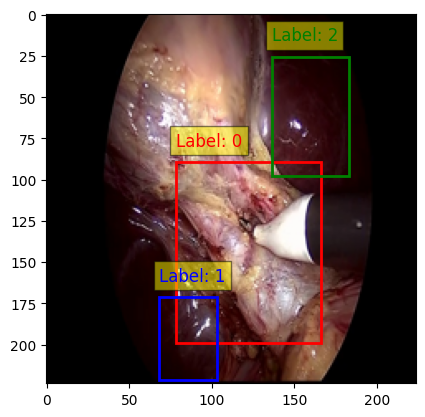

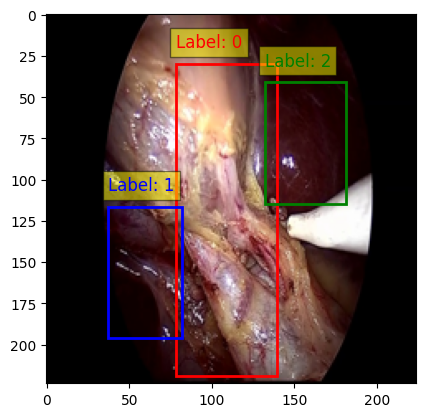

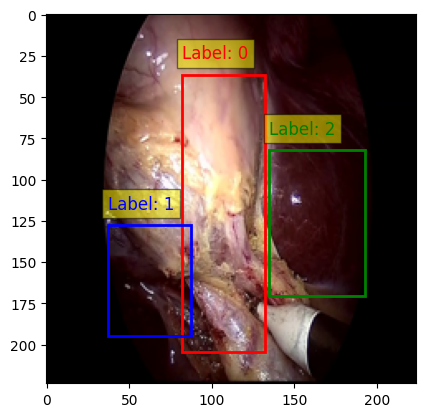

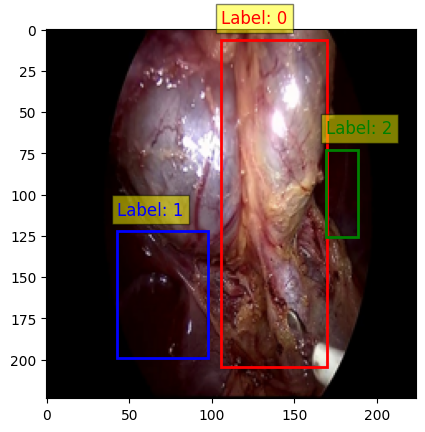

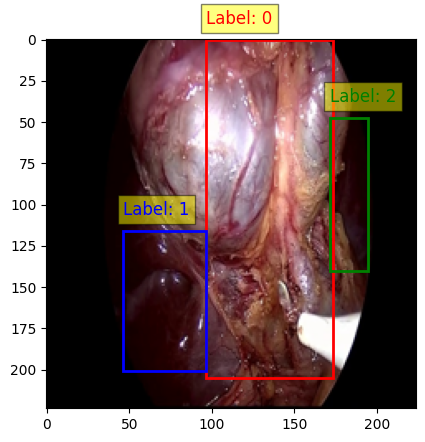

In [14]:
# Mostrar las imágenes y sus cuadros delimitadores ajustados
for i in range(5):
    plt.imshow(images[i])
    
    bbox_list = targets['bounding_box'][i]
    class_list = targets['class_label'][i]
    
    for bbox, class_label in zip(bbox_list, class_list):
        label = np.argmax(class_label)
        color = 'red' if label == 0 else ('blue' if label == 1 else 'green')
        plt.gca().add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], 
                                          edgecolor=color, facecolor='none', linewidth=2))
        plt.text(bbox[0], bbox[1] - 10, f"Label: {label}", color=color, fontsize=12, 
                 bbox=dict(facecolor='yellow', alpha=0.5))
    
    plt.show()

In [15]:
images.shape

(61, 224, 224, 3)

**División train-test**

**Entrenamiento de modelo de transfer learning**